<a href="https://colab.research.google.com/github/Maria-Hihi-Haha/The-Great-Exit/blob/main/Great_Exit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Установка вебдрайвера и части необходимых библиотек.

Эта часть проекта была взята из открытого [источника](https://medium.com/@MinatoNamikaze02/running-selenium-on-google-colab-a118d10ca5f8)

In [ ]:
### FROM

%%shell
sudo apt -y update
sudo apt install -y wget curl unzip
wget http://archive.ubuntu.com/ubuntu/pool/main/libu/libu2f-host/libu2f-udev_1.1.4-1_all.deb
dpkg -i libu2f-udev_1.1.4-1_all.deb
wget https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
dpkg -i google-chrome-stable_current_amd64.deb

wget -N https://edgedl.me.gvt1.com/edgedl/chrome/chrome-for-testing/118.0.5993.70/linux64/chromedriver-linux64.zip -P /tmp/
unzip -o /tmp/chromedriver-linux64.zip -d /tmp/
chmod +x /tmp/chromedriver-linux64/chromedriver
mv /tmp/chromedriver-linux64/chromedriver /usr/local/bin/chromedriver
pip install selenium chromedriver_autoinstaller

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,088 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [2,439 kB]
Get:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,885 kB]
Get:13 http://

In [ ]:
!pip install requests beautifulsoup4 pandas selenium webdriver-manager

## Создание датафрейма с компаниями, которые ушли из России

In [ ]:
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

from selenium import webdriver
import chromedriver_autoinstaller

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless') # this is must
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chromedriver_autoinstaller.install()

driver = webdriver.Chrome(options=chrome_options)

### END FROM

**Чтобы прогнать код успешно, обязательно надо включить VPN.** Сайт, с которого скачиваются данные не доступен в России.

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
import numpy as np


url = 'https://leave-russia.org/companies-that-exited'
driver.get(url)

company_details = []
while True:
    # Wait for the companies to load
    WebDriverWait(driver, 10).until(EC.presence_of_all_elements_located((By.CLASS_NAME, 'card.transfer.exited')))

    # Get page source and parse with BeautifulSoup
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    company_elements = soup.find_all('div', {'class': 'card transfer exited'})

    for element in company_elements:
        company_name = element['data-link'].split('/')[-1].title()
        company_name = company_name.replace('-', ' ')

        cbody_div = element.find('div', {'class': 'cbody'})
        if cbody_div:
            stats_div = cbody_div.find('div', {'class': 'stats'})
            if stats_div:
                labels = ['Revenue(RF)', 'Assets(RF)', 'Capital(RF)', 'Glob.Revenue', 'Plants', 'Staff(RF)',
                          'Taxes(RF)']
                corresp_values = []

                for label in labels:
                    info_div = stats_div.find(lambda tag: tag.name == 'div' and tag.text.strip().startswith(label))
                    num = str(info_div).replace('Staff(RF), 2021', '')
                    num = re.sub("[^0-9]", "", num)
                    if num:
                        corresp_values.append(int(num))
                    else:
                        corresp_values.append(None)

                date_decision = element.find('div', {'class': 'decision'}).find('div',
                                                                                class_='date').text.strip() if element.find(
                    'div', {'class': 'decision'}).find('div', class_='date') else None

                if date_decision is None or not '202' in date_decision:
                    corresp_values.append(None)
                else:
                    better_date = date_decision.replace(" Statement", "")
                    corresp_values.append(better_date)

                lzone = cbody_div.find('div', class_='lzone splitline')
                country_label = lzone.find('a', title=True)
                if country_label:
                    country_label = str(country_label).split()
                    first, last = country_label[-1].index('"'), country_label[-1].rindex('"')
                    country = country_label[-1][first+1:last]
                    corresp_values.append(country)
                else:
                    corresp_values.append(None)
                company_details.append([company_name] + corresp_values)
    try:
        # Attempt to click the "120 More Companies" button
        load_more_button = driver.find_element(By.XPATH, '//*[@id="np_button_holder"]')
        load_more_button.click()
        time.sleep(2)  # Allow time for the new content to load
    except:
        # Break the loop if the button is not found or no more companies to load
        break

driver.quit()

# Create a DataFrame and save to CSV
all_labels = ['Revenue(RF)', 'Assets(RF)', 'Capital(RF)', 'Glob.Revenue', 'Plants', 'Staff(RF)', 'Taxes(RF)',
              'Date of Decision', 'Country']
exit_df = pd.DataFrame(company_details, columns=['Company Name'] + all_labels)

In [ ]:
exit_df

,Company Name,Revenue(RF),Assets(RF),Capital(RF),Glob.Revenue,Plants,Staff(RF),Taxes(RF),Date of Decision,Country
0,British American Tobacco,4233.0,1986.0,1025.0,34080.0,NaN,2906.0,371.0,"September 07, 2023",
1,Veon,4088.0,5779.0,611.0,7843.0,NaN,26453.0,8.0,"October 09, 2023",Netherlands
2,Renault Group,3116.0,3507.0,667.0,48778.0,1.0,80285.0,972.0,"February 16, 2023",France
3,Danone,3002.0,1082.0,348.0,29084.0,17.0,8000.0,NaN,"May 17, 2024",France
4,International Paper,2951.0,4596.0,907.0,19363.0,NaN,15508.0,3.0,"September 18, 2023",USA
...,...,...,...,...,...,...,...,...,...,...
1074,Velux Group,NaN,NaN,NaN,NaN,NaN,175.0,NaN,"June 20, 2023",Denmark
1075,Wartsila,NaN,12.0,10.0,5074.0,NaN,109.0,4.0,"March 04, 2022",Finland
1076,Wilhelmsen Ship Management,NaN,NaN,NaN,943.0,NaN,NaN,NaN,"December 18, 2023",Norway
1077,Wpp Plc,NaN,NaN,NaN,15700.0,NaN,1400.0,NaN,"September 11, 2022",


## Создаем датафрейм с компаниями, которые остаются в России.

In [ ]:
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

from selenium import webdriver
import chromedriver_autoinstaller

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless') # this is must
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chromedriver_autoinstaller.install()

driver = webdriver.Chrome(options=chrome_options)

### END FROM

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Base URL of the webpage
base_url = 'https://leave-russia.org/staying-companies'
ajax_url = 'https://leave-russia.org/staying-companies?event=ajax&action=ArticleList.displayCache.1079&page='

# Function to get company details from a page
def get_companies_from_page(soup):
    company_elements = soup.find_all('div', class_='card continue stay')
    company_details = []
    for element in company_elements:
        data_link = element.get('data-link')
        if data_link:
            # Extract the company name from the data-link attribute
            company_name = data_link.split('/')[-1].title()  # The company name is the last part of the URL
            company_name = company_name.replace('-', " ")

            # Extract the country from the title attribute
            country_tag = element.find('a', class_='cshort')
            if country_tag and 'title' in country_tag.attrs:
                country = country_tag['title']
            else:
                country = None

            # Add the details to the list
            company_details.append({'Company': company_name, 'Country': country})
    return company_details

# Initial request to fetch the first page
response = requests.get(base_url)
html_content = response.content
soup = BeautifulSoup(html_content, 'html.parser')

# Extract initial company details
all_company_details = get_companies_from_page(soup)

# Start iterating over the AJAX pages
page_number = 1
while True:
    # Construct the AJAX URL for the next page
    ajax_page_url = ajax_url + str(page_number)
    response = requests.get(ajax_page_url)

    # Check if the response is empty or no new companies are loaded
    if response.status_code != 200 or not response.content.strip():
        break

    # Parse the new HTML content
    soup = BeautifulSoup(response.content, 'html.parser')

    # Extract company details from this page
    new_company_details = get_companies_from_page(soup)

    # If no new companies are found, stop the loop
    if not new_company_details:
        break

    # Add new companies to the list
    all_company_details.extend(new_company_details)

    # Move to the next page
    page_number += 1

# Create a DataFrame from the list of dictionaries
stay = pd.DataFrame(all_company_details)
stay


,Company,Country
0,Philip Morris,USA
1,Leroy Merlin,France
2,Japan Tobacco International,Switzerland
3,Chery Automobile,China
4,Pepsico,USA
...,...,...
1672,Zilog,USA
1673,Zippo,USA
1674,Zoller,Germany
1675,Zoom,USA


## Проверяем гипотезу 1: Чем выше соотношение выручки в России к выручке в мире, тем медленее компания уходила из России.



Отчищаем базу данных от строк, в которых нет значений по выручкам или по времени принятия решения.

In [ ]:
# Filter out rows where "Revenue[RF]" or "Glob.Revenue" is "None"
filtered_exited = exit_df[(exit_df["Revenue(RF)"].notna()) & (exit_df["Glob.Revenue"].notna()) & (exit_df["Date of Decision"].notna())]
filtered_exited


,Company Name,Revenue(RF),Assets(RF),Capital(RF),Glob.Revenue,Plants,Staff(RF),Taxes(RF),Date of Decision,Country
0,British American Tobacco,4233.0,1986.0,1025.0,34080.0,NaN,2906.0,371.0,"September 07, 2023",
1,Veon,4088.0,5779.0,611.0,7843.0,NaN,26453.0,8.0,"October 09, 2023",Netherlands
2,Renault Group,3116.0,3507.0,667.0,48778.0,1.0,80285.0,972.0,"February 16, 2023",France
3,Danone,3002.0,1082.0,348.0,29084.0,17.0,8000.0,NaN,"May 17, 2024",France
4,International Paper,2951.0,4596.0,907.0,19363.0,NaN,15508.0,3.0,"September 18, 2023",USA
...,...,...,...,...,...,...,...,...,...,...
1031,Infineon,1.0,1.0,1.0,14218.0,NaN,4.0,NaN,"November 16, 2023",Germany
1034,Nu Skin,1.0,NaN,NaN,2226.0,NaN,NaN,1.0,"April 10, 2023",USA
1035,Srv,1.0,11.0,9.0,986.0,NaN,25.0,NaN,"May 06, 2024",Finland
1036,Talgo,1.0,NaN,NaN,588.0,NaN,NaN,NaN,"October 20, 2023",Spain


Зависимость от Российского рынка частично можно понять исходя из того, какую долю выручка в России занимает в глобальной прибыли. Мы считаем это соотношение, и создаем новый датафрейм только с нужными значениями.


In [ ]:

# Calculate the ratio of "Revenue[RF]" to "Glob.Revenue"
filtered_exited["Ratio"] = filtered_exited["Revenue(RF)"] / filtered_exited["Glob.Revenue"]

# Create the new DataFrame
new_exit_df = filtered_exited[["Company Name", "Ratio", "Date of Decision"]]

new_exit_df

<ipython-input-27-1fffafc82b0b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_exited["Ratio"] = filtered_exited["Revenue(RF)"] / filtered_exited["Glob.Revenue"]


,Company Name,Ratio,Date of Decision
0,British American Tobacco,0.124208,"September 07, 2023"
1,Veon,0.521229,"October 09, 2023"
2,Renault Group,0.063881,"February 16, 2023"
3,Danone,0.103218,"May 17, 2024"
4,International Paper,0.152404,"September 18, 2023"
...,...,...,...
1031,Infineon,0.000070,"November 16, 2023"
1034,Nu Skin,0.000449,"April 10, 2023"
1035,Srv,0.001014,"May 06, 2024"
1036,Talgo,0.001701,"October 20, 2023"


In [ ]:
!pip install matplotlib

ERROR: Operation cancelled by user


Строим график, пользуясь новым датафреймом и функцией scatter.

<ipython-input-28-05f60200117d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_exit_df['Date of Decision'] = pd.to_datetime(new_exit_df['Date of Decision'])


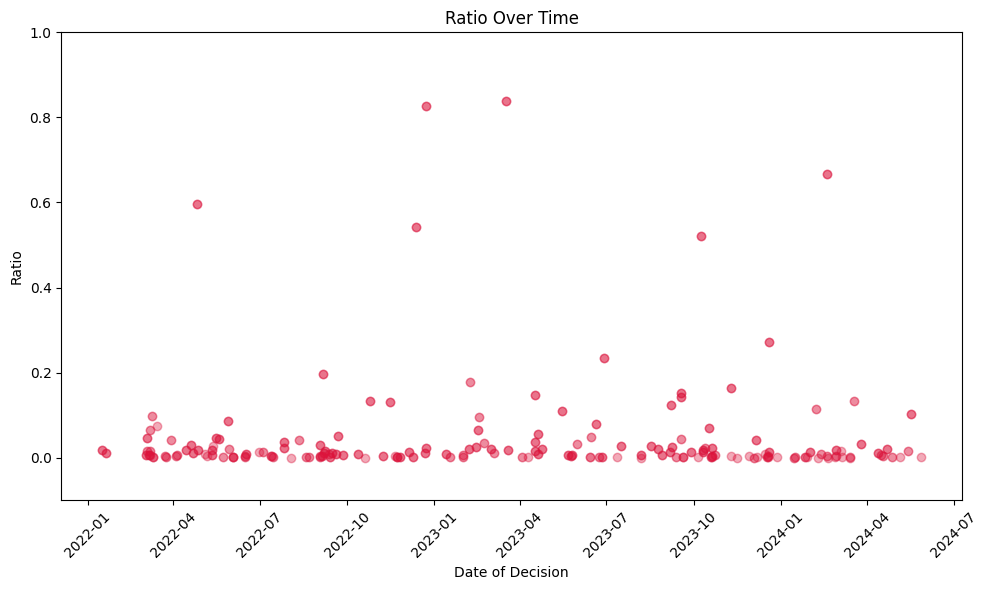

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming new_exit_df is your DataFrame

# Convert the 'Decision Date' column to datetime format
new_exit_df['Date of Decision'] = pd.to_datetime(new_exit_df['Date of Decision'])

# Plotting
plt.figure(figsize=(10, 6))  # Optional: Adjusts the figure size
plt.scatter(new_exit_df['Date of Decision'], new_exit_df['Ratio'], color='crimson', alpha=0.2)
plt.xlabel('Date of Decision')
plt.ylabel('Ratio')
plt.title('Ratio Over Time')
plt.xticks(rotation=45)  # Rotates the x-axis labels for better readability
plt.tight_layout()  # Adjusts subplot params so that the subplot(s) fits in to the figure area
plt.ylim(-0.1, 1)

plt.show()




График не дает однозначный ответ, так как множество компаний изначально имели низкое соотношение прибылей в России и вне. Попробуем получить ответ численно.
Мы посчитаем медианное время ухода из России. Разделим компании на две категории по этому критерию и посчитаем среднее время ухода в обоих категориях.

In [ ]:
base_date = pd.Timestamp('2022-02-24')
new_exit_df['Days'] = (new_exit_df['Date of Decision'] - base_date).dt.days
new_exit_df

<ipython-input-29-2b5c507d12b9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_exit_df['Days'] = (new_exit_df['Date of Decision'] - base_date).dt.days


,Company Name,Ratio,Date of Decision,Days
0,British American Tobacco,0.124208,2023-09-07,560
1,Veon,0.521229,2023-10-09,592
2,Renault Group,0.063881,2023-02-16,357
3,Danone,0.103218,2024-05-17,813
4,International Paper,0.152404,2023-09-18,571
...,...,...,...,...
1031,Infineon,0.000070,2023-11-16,630
1034,Nu Skin,0.000449,2023-04-10,410
1035,Srv,0.001014,2024-05-06,802
1036,Talgo,0.001701,2023-10-20,603


In [ ]:
median_ratio = new_exit_df['Ratio'].median()
median_ratio


0.012058045199395155

In [ ]:
new_exit_df['AboveMedian'] = new_exit_df['Ratio'].apply(lambda x: 'Yes' if x > median_ratio else 'No')
average_days_above_median = new_exit_df[new_exit_df['AboveMedian'] == 'Yes']['Days'].mean()
average_days_below_median = new_exit_df[new_exit_df['AboveMedian'] == 'No']['Days'].mean()


<ipython-input-31-bd3e4c4067f1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_exit_df['AboveMedian'] = new_exit_df['Ratio'].apply(lambda x: 'Yes' if x > median_ratio else 'No')


In [ ]:
average_days_above_median


384.841059602649

In [ ]:
average_days_below_median

377.682119205298

Мы считаем разницу до 14 дней незначительной. Получается, что если смотреть по медиане, разницы как таковой и нет((
Возможно медиана просто является плохим показателем. Попробуем найти среднее для топ 10% компаний с высоким ratio и среднее для ботом 10% компаний с низким ratio.

In [ ]:
import pandas as pd

sorted_exit_df = new_exit_df.sort_values(by='Ratio', ascending=False)

# Calculate the quantile for the top 10%
top_10_percentile = sorted_exit_df['Ratio'].quantile(0.90)  # 90th percentile for top 10%
lower_10_percentile = sorted_exit_df['Ratio'].quantile(0.10)  # 90th percentile for top 10%

# Select the top 10% of companies by 'Ratio'
top_10_percent_companies = sorted_exit_df[sorted_exit_df['Ratio'] >= top_10_percentile]
lower_10_percent_companies = sorted_exit_df[sorted_exit_df['Ratio'] <= top_10_percentile]

# Calculate the average 'Ratio' for the selected companies
average_ratio_top_10_percent = top_10_percent_companies['Ratio'].mean()
average_ratio_lower_10_percent = lower_10_percent_companies['Ratio'].mean()


In [ ]:
new_exit_df['In_top_10%'] = new_exit_df['Ratio'].apply(lambda x: 'Yes' if x > average_ratio_top_10_percent else 'No')
average_days_above_top_10 = new_exit_df[new_exit_df['In_top_10%'] == 'Yes']['Days'].mean()

new_exit_df['In_lower_10%'] = new_exit_df['Ratio'].apply(lambda x: 'Yes' if x < average_ratio_lower_10_percent else 'No')
average_days_below_top_10 = new_exit_df[new_exit_df['In_lower_10%'] == 'Yes']['Days'].mean()


<ipython-input-42-edf89e8a5677>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_exit_df['In_top_10%'] = new_exit_df['Ratio'].apply(lambda x: 'Yes' if x > average_ratio_top_10_percent else 'No')
<ipython-input-42-edf89e8a5677>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_exit_df['In_lower_10%'] = new_exit_df['Ratio'].apply(lambda x: 'Yes' if x < average_ratio_lower_10_percent else 'No')


In [ ]:
average_days_above_top_10

393.0

In [ ]:
average_days_below_top_10

380.7953367875648

Снова получили несущественную разницу. Получается, что зависимость от доходов в России несущественно влияло на скорость принятия решения о выходе из рынка. Явно были другие существенные причины для принятия решения о выходе.

## Проверяем гипотезу 2: чем западнее страна на карте, тем выше соотношение компаний, которые ушли, к компаниям, которые были до 24 февраля.

У нас есть два датафрейма: с компаниями, которые ушли, и с компаниями, которые остаются в стране. Мы можем посчитать, сколько из каждой страны в датафреймах ушло и осталось компаний. Посчитать индекс "исхода" и сделать красивую карту, где интенсивность цвета будет обозначать близость индекса к единице.

In [ ]:
import pandas as pd

# Step 1: Count occurrences of each country
country_counts_stay = stay['Country'].value_counts().reset_index()

# Step 2: Rename columns to 'Country' and 'Count'
country_counts_stay.columns = ['Country', 'Count_stay']

# Step 3: Sort the DataFrame alphabetically by country name
country_counts_stay = country_counts_stay.sort_values(by='Country').reset_index(drop=True)
country_counts_stay

           Country  Count_stay
0       Afganistan           1
1        Argentina           1
2          Armenia           2
3        Australia           5
4          Austria          42
..             ...         ...
85         Ukraine           2
86  United Kingdom          80
87      Uzbekistan           7
88       Venezuela           1
89         Vietnam           1

[90 rows x 2 columns]


In [ ]:
import pandas as pd

# Assuming 'exit_df' is the DataFrame containing company details with 'Company' and 'Country' columns

# Step 1: Count occurrences of each country
country_counts_exit = exit_df['Country'].value_counts().reset_index()

# Step 2: Rename columns to 'Country' and 'Count'
country_counts_exit.columns = ['Country', 'Count_exit']

# Step 3: Sort the DataFrame alphabetically by country name
country_counts_exit = country_counts.sort_values(by='Country').reset_index(drop=True)

# Print the sorted DataFrame
print(country_counts)



          Country  Count_exit
0                          97
1       Australia          10
2         Austria          24
3      Azerbaijan           2
4         Belgium           4
5          Canada          14
6          Cyprus          13
7         Denmark          40
8         Estonia           3
9         Finland          82
10         France          88
11        Germany         138
12      Greenland           6
13        Hungary           1
14  International          11
15        Ireland          18
16         Israel           2
17          Italy          10
18          Japan          40
19     Kazakhstan           8
20         Latvia           4
21  Liechtenstein           2
22      Lithuania          10
23     Luxembourg           9
24    Netherlands          56
25         Norway          22
26         Poland           9
27      Singapore           4
28          Spain          15
29         Sweden          67
30    Switzerland          43
31         Turkey           2
32        

In [ ]:
import pandas as pd


# Performing a full outer join on the 'Country' column
combined_df = pd.merge(country_counts_stay, country_counts_exit, on='Country', how='outer')

# Sorting the resulting DataFrame alphabetically by country name
combined_df = combined_df.sort_values(by='Country').reset_index(drop=True)
combined_df = combined_df.fillna(0)
combined_df['Total'] = combined_df['Count_stay'] + combined_df['Count_exit']

# Print the combined DataFrame
print(combined_df)


           Country  Count_stay  Count_exit  Total
0                          0.0        97.0   97.0
1       Afganistan         1.0         0.0    1.0
2        Argentina         1.0         0.0    1.0
3          Armenia         2.0         0.0    2.0
4        Australia         5.0        10.0   15.0
..             ...         ...         ...    ...
87         Ukraine         2.0         4.0    6.0
88  United Kingdom        80.0         0.0   80.0
89      Uzbekistan         7.0         0.0    7.0
90       Venezuela         1.0         0.0    1.0
91         Vietnam         1.0         0.0    1.0

[92 rows x 4 columns]


Создаем два индекса: индекс исхода и индекс присутствия. Их мы будем использовать для окрашивания карты.

In [ ]:
import pandas as pd

# Assuming country_counts_stay and country_counts_exit are already defined as shown in your code snippet

# Merge the two datasets on the 'Country' column
merged_df = pd.merge(country_counts_stay, country_counts_exit, on='Country', how='outer')

# Rename the columns appropriately
merged_df.columns = ['Country', 'Count_stay', 'Count_exit']

# Reset the index if necessary
merged_df.reset_index(drop=True, inplace=True)
merged_df = merged_df.fillna(0)
merged_df['Total'] = merged_df['Count_stay'] + merged_df['Count_exit']
merged_df['Exodus Index'] = merged_df['Count_exit']/merged_df['Total']
merged_df['Stay Index'] = -(merged_df['Count_stay']/merged_df['Total'])
merged_df



,Country,Count_stay,Count_exit,Total,Exodus Index,Stay Index
0,Afganistan,1.0,0.0,1.0,0.000000,-1.000000
1,Argentina,1.0,0.0,1.0,0.000000,-1.000000
2,Armenia,2.0,0.0,2.0,0.000000,-1.000000
3,Australia,5.0,10.0,15.0,0.666667,-0.333333
4,Austria,42.0,24.0,66.0,0.363636,-0.636364
...,...,...,...,...,...,...
87,Uzbekistan,7.0,0.0,7.0,0.000000,-1.000000
88,Venezuela,1.0,0.0,1.0,0.000000,-1.000000
89,Vietnam,1.0,0.0,1.0,0.000000,-1.000000
90,,0.0,97.0,97.0,1.000000,-0.000000


In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

countries_gdf = gpd.read_file('shapes/ne_110m_admin_0_countries.shp')

# Merge the DataFrames
merged_gdf = df.set_index('Country').join(countries_gdf.set_index('name'))

# Calculate the colormap
norm = plt.Normalize(vmin=df['Exodus Index'].min(), vmax=df['Exodus Index'].max())
colors = plt.cm.Reds(norm(merged_gdf['Exodus Index']))

# Plot the map
fig, ax = plt.subplots(1, figsize=(10, 10))
ctx.add_basemap(ax, source=ctx.providers.Stamen.TerrainRetina)
merged_gdf.plot(column=colors, legend=True, cmap=plt.cm.Reds, linewidth=0.8, ax=ax, edgecolor='0.8')
plt.show()


ERROR:fiona._env:shapes/ne_110m_admin_0_countries.shp: No such file or directory


DriverError: shapes/ne_110m_admin_0_countries.shp: No such file or directory